## Diagnosing Pediatric Pneumonia from Chest X-rays Using a Convolutional Neural Network  
### Caitlin Streamer

*Additional Materials:*   [GitHub](https://github.com/c-streams/Pneumonia) |   [Portfolio](https://caitlinstreamer.wordpress.com/)   

**Outline**
- [Executive Summary](#exec)
- [Introduction](#intro)
    - [Artificial Intelligence as Clinical Decision Support Systems](#AI)
- [Import Images](#import)
- [Image Analysis](#EDA)
- [Image Processing](#process)
- [Data Augmentation](#aug)
- [Modeling](#model)
    - [CNN Model & Evaluation](#cnn)
    - [Transfer Learning VGG16 Model & Evaluation](#transfer)
    - [Transfer Learning InceptionV3 Model & Evaluation](#transfer_2)
- [Conclusions](#conc)
- [Next Steps](#next)
- [References](#ref)


----------------------------------------------------------------------------------------------------------------------
<a id='exec'></a>
### Executive Summary 
 
Medical imaging, such as X-rays, are important tools used to help diagnose certain conditions. The limited availability of highly trained doctors who can interpret these images, however, can lead to a slow diagnostic process,  delaying needed treatment. Childhood pneumonia is one such condition that when diagnosed early can be life saving. According to the World Health Organization, pneumonia is responsible for 16% of child deaths under 5 years old [1]. In an attempt to address this problem, I have built an image based deep learning model to diagnose pediatric pneumonia from chest X-rays. It is my hope that such a model could be utilized to expedite the disease screening process and serve as a second opinion to trained physicians. 

I utilized a dataset from a recent study by Kermany et al. who developed a generalized artificial intelligence system to diagnose conditions such as macular degeneration, diabetic retinopathy, and pneumonia [2]. In this study, over 5,000 X-rays where obtained from children ages 1-5 at Guangzhou Women and Children’s Medical Center, Guangzhou, China during regular clinical visits. The images were labeled by two expert physicians and verified by a third physician. 

Using Keras with a TensorFlow backend, I built newly trained Convolutional Neural Networks (CNNs) and compared them to a transfer learning approach with the VGG16 and InceptionV3 models trained on the ImageNet dataset to address both binary and multi-class classification problems. Binary classification was defined as identifying normal chest X-rays from any type of pneumonia and the multi-class classification problem as distinguishing normal X-rays from bacterial and viral pneumonia cases. The models were trained on an AWS Deep Learning AMI (Ubuntu 16.4) Version 11.0 GPU enabled computer with 4 virtual CPUs and 61 GiB memory.   

Optimizing for sensitivity with a target specificity over 65%, my binary classification CNN performed the best with a ROC score of 0.96, 88% accuracy, 99% sensitivity, and 71% specificity. These results are close to that of human experts. I suspect that my model performed better than the transfer learning approaches due to its simplicity. Since neural networks inherently overfit, a simpler model architecture will reduce overfitting. Optimizing for the same metrics, the multi-class VGG16 model performed the best with a ROC score of 0.95, 82% accuracy, 99% sensitivity, and 66% specificity. Identification of viral pneumonia was consistently lower in all 3 multi-class models. I suspect this is due to the small sample size available. I believe additional data is required to improve the performance of the 3 class models. 

To conclude, my results demonstrate the feasibility of using a CNN to diagnose pneumonia from chest X-rays with a respectable accuracy. Future exploration is required to further improve these models as well as replicate the findings of Kermany et al. 

-------------------------------------------------------------------------------------------------------------------

<a id='intro'></a>
### Introduction  

Pneumonia is a type of acute respiratory infection impacting the lungs that is caused by a variety of infectious agents such as bacteria, viruses, and fungi [1]. When afflicted with pneumonia, alveoli in the lungs fill with fluid and pus making it difficult to breath and prevent the intake of oxygen. In children, pneumonia is the largest infectious cause of death worldwide, responsible for 16% of deaths under 5 years old [1]. The most common treatment for bacterial pneumonia is antibiotics while for viral pneumonia is supportive care and anti-viral medication [2]. If left untreated, pneumonia can be fatal. Because different types of pneumonia require different treatments, chest X-rays are an important tool used to help distinguish types in addition to presentable symptoms. Due to the infectious nature of pneumonia, it requires an immediate treatment. Diagnosing pneumonia and its cause early is critical.    

Limited availability of highly trained doctors who can interpret chest X-rays, however, leads to slow diagnostic processes, delaying much needed treatment. This is especially true in south Asia and sub-Saharan Africa where rates of pneumonia are much higher [1].     

<a id='AI'></a>
### Artificial Intelligence as Clinical Decision Support Systems  

Artificial intelligence (AI) has the potential to revolutionize the field of radiology and transform image based medical diagnostics and treatment. While even highly trained physicians may see hundreds of thousands of X-rays in the course of their training and career, a machine learning model can be trained on millions. Interpretability and reliability, however, remain challenges for such AI diagnostic systems [2]. These challenges notwithstanding, these systems can still play an important role as a support system for human experts in expediting disease screening processes and serving as a second opinion.  


<a id='import'></a>
### Import Images 

The dataset I obtained is composed of a train and test folder, each with normal and pneumonia sub-folders. Within the condition type folders there are jpeg chest X-ray images. In the test data there are 390 pneumonia X-rays and 234 normal. In the train data there are 3,883 pneumonia x-rays and 1,349 normal. The pneumonia images are further classified by their type, bacterial or viral, in their file names. 

In [1]:
# Import libraries

import glob
import cv2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from skimage.io import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical 
from keras.applications import VGG16, InceptionV3
from keras.optimizers import Adam
import keras.backend as K
from sklearn.utils import resample
from sklearn import metrics

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In order to load the images, I defined directory paths with the goal to first create a dataframe of each image URL and its associated label. I defined label = 1 as Pneumonia and label = 0 as normal. I created a function to import the images and create a dataframe for the train and test data below.

In [2]:
# Function to create train and test dataframes composed of image URL and label 
def import_format(directory):
    # Define directory paths for the images 
    dir_normal_path = Path('data/'+ directory +'/NORMAL')
    dir_pne_path = Path('data/' + directory + '/PNEUMONIA')
    
    # Collect image paths from each directory 
    dir_normal = dir_normal_path.glob('*.jpeg')
    dir_pne = dir_pne_path.glob('*.jpeg')

    # Create list with the image paths and label (label = 0 NORMAL, label = 1 PNEUMONIA)
    dir_list = []
    for pic in dir_normal:
        dir_list.append((pic, 0))
    
    for pic in dir_pne:
        dir_list.append((pic, 1))
        
    # Create dataframes from the train and test lists 
    df = pd.DataFrame(dir_list, columns = ['image_path', 'label'])
    
    # Shuffle dataframe so that the classes aren't in order
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [37]:
# Import and create train and test dataframes
test = import_format('test')
train = import_format('train')
train.head()

,image_path,label
0,data/train/PNEUMONIA/person946_bacteria_2871.jpeg,1
1,data/train/PNEUMONIA/person1012_bacteria_2943....,1
2,data/train/NORMAL/NORMAL2-IM-1292-0001.jpeg,0
3,data/train/PNEUMONIA/person1563_bacteria_4092....,1
4,data/train/PNEUMONIA/person299_bacteria_1416.jpeg,1


In [4]:
# Inspect train and test shape - test set is significantly smaller 
train.shape, test.shape

((5232, 2), (624, 2))

<a id='EDA'></a>
### Image Analysis 

In order to determine the amount of preprocessing required before modeling, I investigated the images themselves. I focused on answering the following questions: 

1) Is the data unbalanced?   
2) Are the images the same size? Do they have varying aspect ratios?  
3) Are the images grayscale or do they have multiple color channels?  

To get a feel for the data, I first displayed a few sample x-rays.  

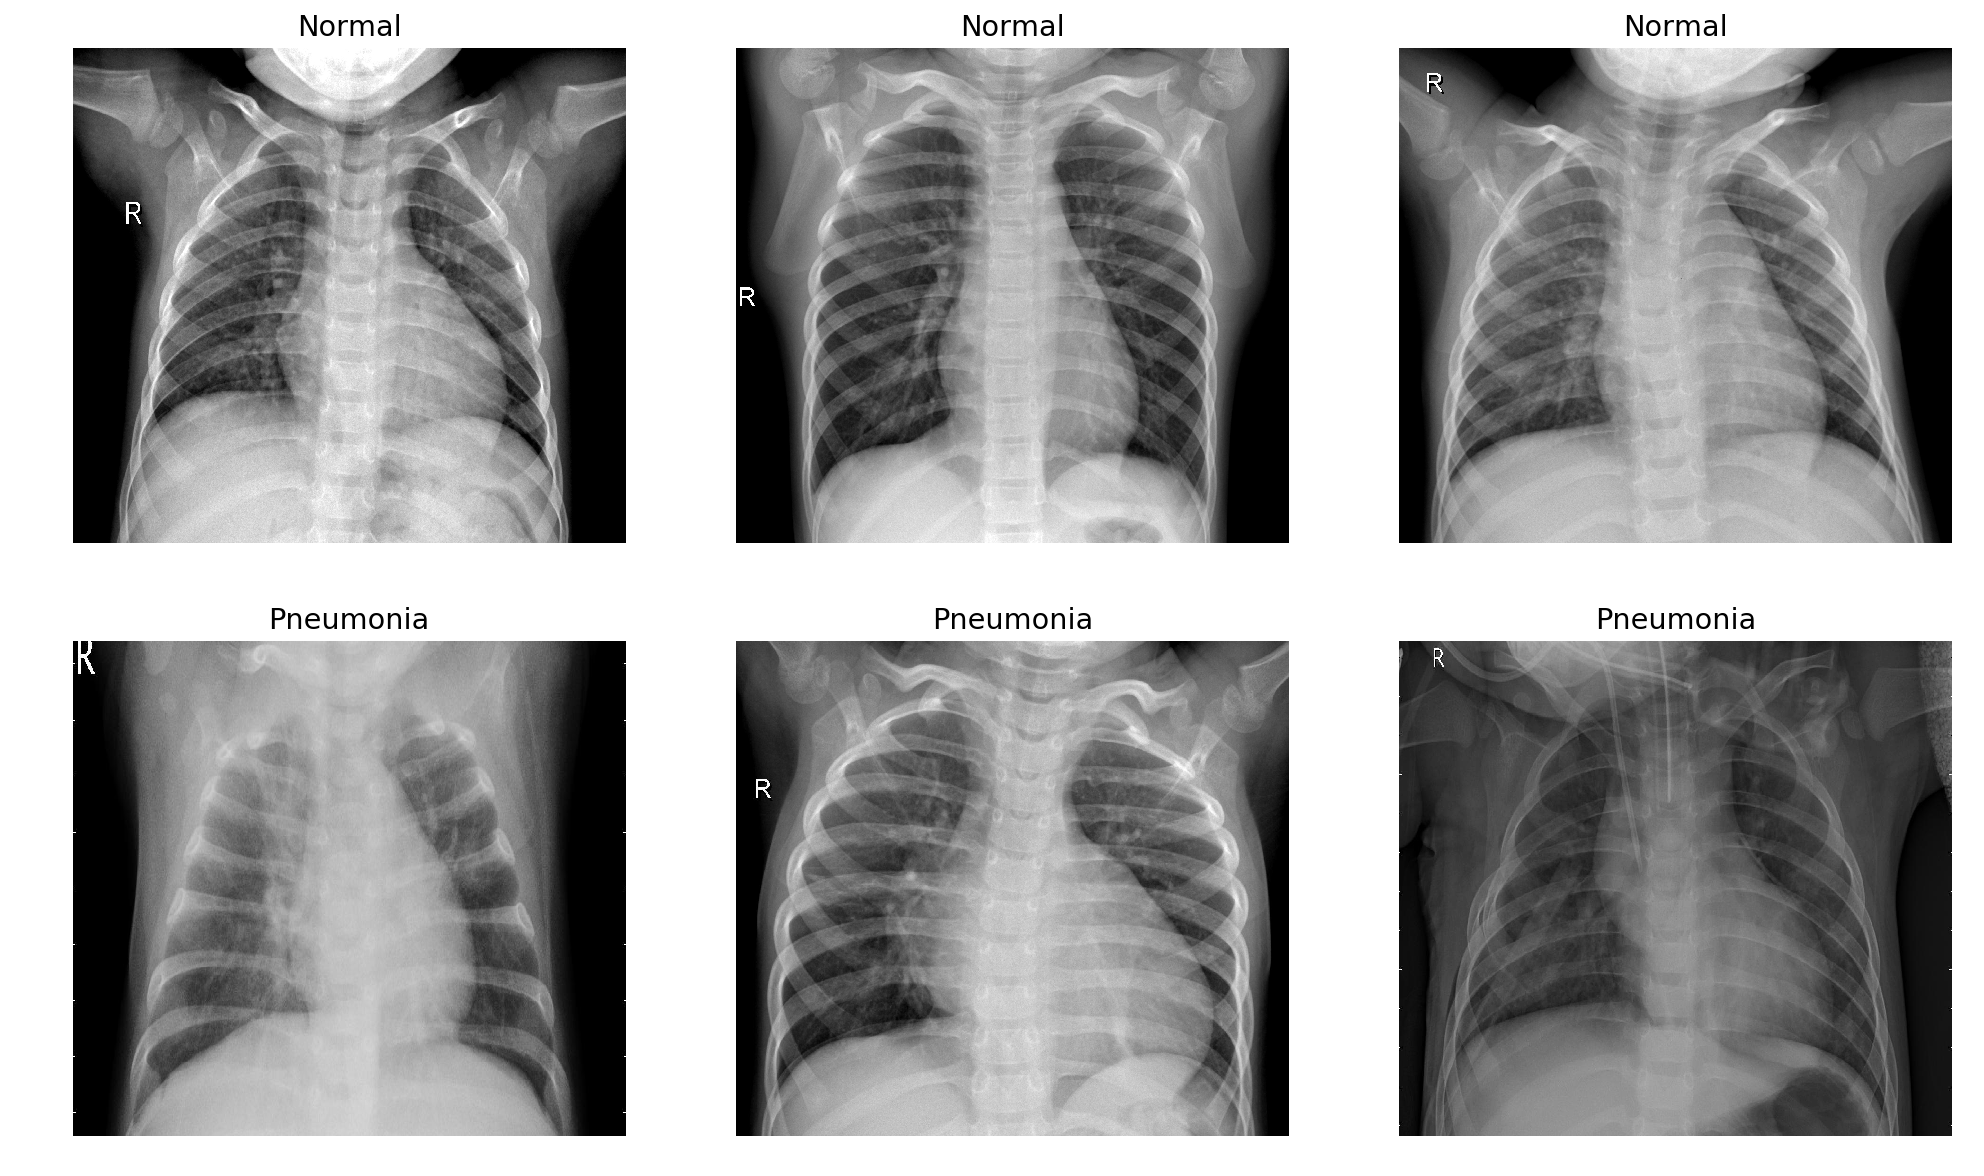

In [5]:
# Select first 3 normal and pneumonia images 
normal = (train[train['label']==0]['image_path'].head(3)).tolist()
pneumonia = (train[train['label']==1]['image_path'].head(3)).tolist()

# Initiate plots 
fig, ax = plt.subplots(2,3, figsize = (15,10))

# Iterate through both sets of 3 images
for i in range(3):
    
    # Read images 
    norm = imread(normal[i])
    pne = imread((pneumonia[i]))
    
    # View images
    ax[0, i].imshow(norm, cmap = 'gray')
    ax[1, i].imshow(pne, cmap = 'gray')
    
    # Labels
    ax[0, i].set_title('Normal')
    ax[1, i].set_title('Pneumonia')
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[1, i].set_aspect('auto')
    ax[0, i].set_aspect('auto');

From the X-rays above, it is not immediately obvious to the untrained eye which cases are which. Luckily machine learning is here to help!

Next I answered question 1: is the data unbalanced?

In [6]:
# Determine fraction of images in each class 
train['label'].value_counts(normalize = True)

1    0.742164
0    0.257836
Name: label, dtype: float64

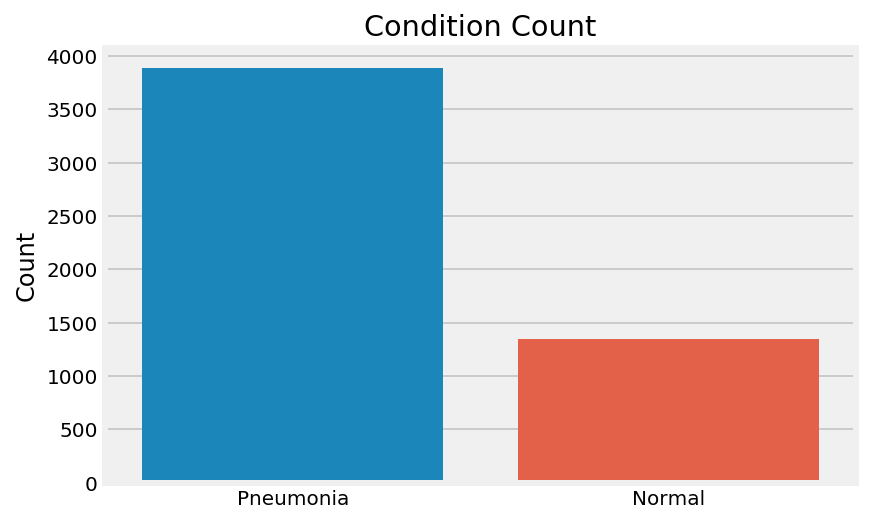

In [7]:
# Visualize class balance 
class_balance = train['label'].value_counts()
sns.barplot(['Pneumonia', 'Normal'], class_balance)
plt.ylabel('Count')
plt.title('Condition Count');

You can see that there are actually more cases of pneumonia in my dataset than normal ones. Unbalanced classes are not uncommon with medical data. Classification algorithms perform better with an even ratio of classes otherwise the minority class is typically underrepresented as a rare event. I will therefore need to balance the classes by oversampling the minority (normal) class.  

Next I addressed questions 2 and 3: Is the data the same shape? 

In [8]:
# Function to identify number of color channels, number of unique image sizes, and number of unique aspect ratios
def image_analysis(df_image_path):
    # Identify number of color channels 
    df_image = df_image_path.tolist()
    color = []
    for i in range(len(df_image)):
        read = cv2.imread(str(df_image[i]))
        color.append(read.shape[2])
    color = set(color)
    print("Number of color channels: ", color)
    
    # Identify number of unique image sizes 
    pic_shape = []
    for i in range(len(df_image)):
        read = cv2.imread(str(df_image[i]))
        pic_shape.append(read.shape[:2])
    image_sizes = len(set(pic_shape))
    print("Number of unique image sizes: ", image_sizes)
    
    # Identify number of unique aspect ratios: aspect ratio = rows / cols
    aspect = []
    for i in range(len(pic_shape)):
        aspect.append(pic_shape[i][0] / pic_shape[i][1])
    aspect = len(set(aspect))
    print("Number of unique aspect ratios: ", aspect)

In [9]:
# Test set has 624 images
image_analysis(test['image_path'])

Number of color channels:  {3}
Number of unique image sizes:  598
Number of unique aspect ratios:  579


In [12]:
# Train set has 5232 images
image_analysis(train['image_path'])

Number of color channels:  {3}
Number of unique image sizes:  4376
Number of unique aspect ratios:  4006


All images in the train and test have 3 color channels. Since I'm using OpenCV, which reads images as BGR, I will have to convert images to RBG during preprocessing. There are many different image shapes in both the train and test sets. They also have different aspect ratios, ranging from 0.38 to 1.07. The majority have rows < cols. I will have to standardize the image size in preprocessing in order to make all the images the same shape, which will improve my modeling.   

Next I plotted histograms of normal and pneumonia cases to get a feel for the color distributions. 

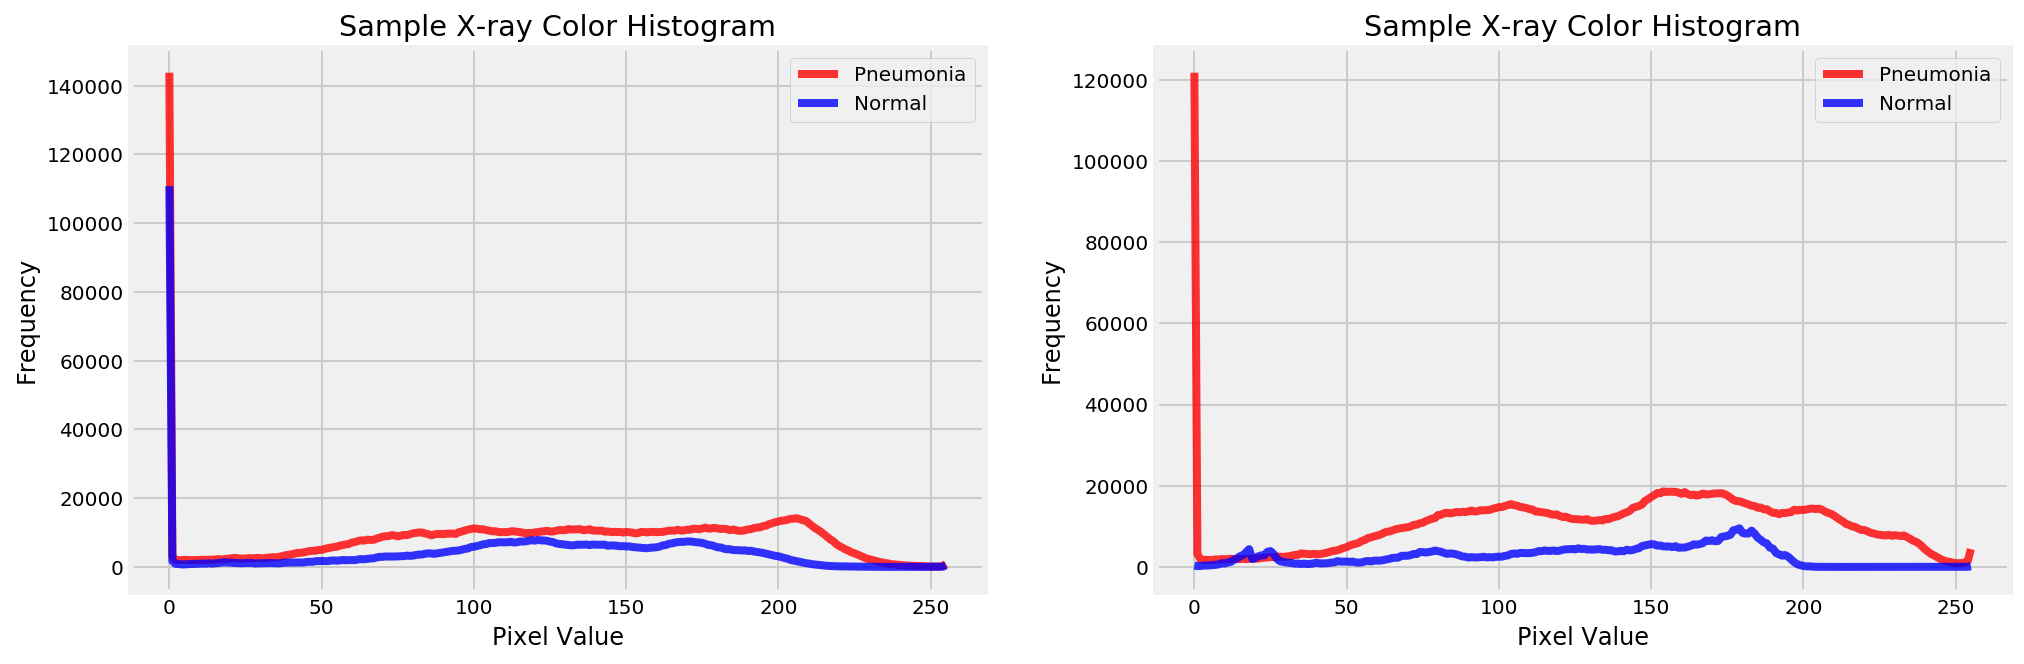

In [38]:
# Compare histograms of normal and pneumonia x-rays
fig, ax = plt.subplots(1,2,figsize = (15,5))

# Identify normal and pneumonia x-rays
normal = (train[train['label']==0]['image_path'].head(10)).tolist()
pneumonia = (train[train['label']==1]['image_path'].head(10)).tolist()

# Read images
imgs = []
for i in range(2):
    imgs.append(cv2.imread(str(normal[i])))
    imgs.append(cv2.imread(str(pneumonia[i])))

# Calculate histograms
hists = []
for i in imgs:
    hists.append(cv2.calcHist([i],[2],None,[256],[0,256]))

# Plot histograms of images
count = 0
for i in range(2):
    ax[i].plot(hists[i + count],color = 'r', label = 'Pneumonia', alpha = 0.8)
    ax[i].plot(hists[i + 1 + count], color = 'b', label = 'Normal', alpha = 0.8)
    count += 1

# Labels
for i in range(2):
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Pixel Value')
    ax[i].set_title('Sample X-ray Color Histogram')
    ax[i].legend(loc = 'best');

While there appears to be a stark difference in the color distributions between pneumonia and normal cases, there is not a consistent pattern. There are consistently large peaks at 0 (black) which makes sense for an X-ray. 

<a id='process'></a>
### Image Processing

From image analysis, I determined that I will need to standardize the shape of all images and augment the minority normal class in the train dataset to artificially balance my classes. I will also need to preprocess the target label class in order to convert class vectors to binary class matrices. These processing steps will increase the performance of my model and will ensure that the minority class is not underepresented. 

I first balanced the classes through manual oversampling (with replacement). 

In [6]:
# Balance classes by oversampling - 50/50 split
minority = train[train['label'] == 0]
majority = train[train['label'] == 1] 
balanced_minority = resample(minority, replace = True, n_samples = 3883 , random_state = 42)
balanced = pd.concat([majority, balanced_minority], axis = 0, ignore_index = True)
balanced = balanced.sample(frac=1).reset_index(drop=True)
balanced['label'].value_counts(normalize = True)

1    0.5
0    0.5
Name: label, dtype: float64

With balanced classes in hand, I defined two functions to process the images to make them ready for modeling. I chose to standardize to a 224 X 224 image size since this is the required input dimension for the VGG16 model I will use for my transfer learning approach.

In [7]:
# Define function to standardize image shape, covert back to RGB, and convert pixel values to floats
def processing(pic):
    pic = cv2.imread(str(pic))
    pic = cv2.resize(pic, (224,224))
    pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
    pic = pic.astype(np.float32)/255
    return pic

In [8]:
# Define function to apply processing to test and train 
def train_test_processing(df_image_path, df_label, num_classes = 2):
    # Process images
    df_processed = df_image_path.map(lambda x: processing(x))
    
    # Convert df_processed into an array
    X = []
    for i in range(df_processed.shape[0]):
        X.append(df_processed[i])
    X = np.array(X)
    
    # Preprocess target label
    y = to_categorical(df_label, num_classes)
    
    return X, y

In [9]:
# Process test images
X_test, y_test = train_test_processing(test['image_path'], test['label'])

# Confirm shape
X_test.shape, y_test.shape

((624, 224, 224, 3), (624, 2))

My X_test is composed of 624 images, each of shape 224 x 224 with 3 color channels (RGB). The y_test has the same number of images and has 2 possible labels. 

In [10]:
# Process train images
X_train, y_train = train_test_processing(balanced['image_path'], balanced['label'])

# Confirm shape
X_train.shape, y_train.shape

((7766, 224, 224, 3), (7766, 2))

My X_train is composed of 7766 images, each of shape 224 x 224 with 3 color channels (RGB). The y_train has the same number of images and has 2 possible labels. 

<a id='aug'></a>
### Data Augmentation 

I utilized data augmentation to increase the overall size of my training set in order to improve the performance of my model. I used the Keras Image Augmentation API, which generates images in real time during the model fitting process. Considering the application of my end model (to diagnose X-rays images), I chose augmentation parameters that are appropriate for variations we might see in X-rays. These include shifting the width and height of the X-rays. Supplementing the training dataset with a variety of image positions will help improve the generalization of my model so that it is not trained on a specific kind of positioning.  

In [11]:
# Define data augmentation parameters 
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1) 

<a id='model'></a>
### Modeling

I created a convolution neural network from scratch (i.e. newly trained weights) and evaluated its performance against a transfer learning approach with the prebuilt VGG16 and InceptionV3 keras CNN models trained on the ImageNet dataset. 

Training a CNN from scratch (starting with a random initialization of weights) is often rare in practice because it is rare to get a large enough dataset to train. Transfer learning is the process of using pretrained weights or extracted features from a pretrained network. These pretained networks typically are very deep networks that have been trained on datasets composed of millions of images. These deep networks can take weeks to train using vast amounts of computing power. Rather than reinventing the wheel, we can use these networks as a basis to classify similar images since the high level features will be similar.  

In order to speed up the time to train these deep networks, the models were trained on an AWS Deep Learning AMI (Ubuntu 16.4) Version 11.0 GPU enabled computer with 4 virtual CPUs and 61 GiB memory. 

<a id='cnn'></a>
**CNN Model & Evaluation**  
After some trial and error, I decided to build a simple CNN with 3 convolution/pooling layers and 2 dense layers in order to minimze the number of parameters. I increase the filter size with each convolution layer in order to gradually identify more details from the x-rays. 

In [31]:
# Define CNN architecture 
model_cnn = Sequential()  

model_cnn.add(Conv2D(32,(3,3), input_shape = X_train.shape[1:], activation = 'relu'))
model_cnn.add((Conv2D(32,(3,3), activation = 'relu')))
model_cnn.add(MaxPooling2D(pool_size= (2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add((Conv2D(64,(3,3), activation = 'relu')))
model_cnn.add((Conv2D(64,(3,3), activation = 'relu')))
model_cnn.add(MaxPooling2D(pool_size= (2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add((Conv2D(128,(3,3), activation = 'relu')))
model_cnn.add((Conv2D(128,(3,3), activation = 'relu')))
model_cnn.add(MaxPooling2D(pool_size= (2,2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())

model_cnn.add(Dense(128, activation = 'relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))

# Compile 
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# View summary
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 53, 53, 64)        0         
__________

In order to improve the performance of my model, I have implemented a callback to reduce the learning rate of the model when the test loss does not improve by a specified amount. Reducing the learning rate is known to improve model performace when learning plateaus. 

In [24]:
# Define callbacks 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [32]:
# Fit model
history_cnn = model_cnn.fit_generator(datagen.flow(X_train, y_train, batch_size=32),epochs= 15, steps_per_epoch= X_train.shape[0] // 32,
                    validation_data=(X_test, y_test), validation_steps = X_test.shape[0] // 32, callbacks = [reduce_lr])

Epoch 1/15
242/242 [==============================] - 80s 329ms/step - loss: 0.6282 - acc: 0.6510 - val_loss: 0.4050 - val_acc: 0.8237
Epoch 2/15
242/242 [==============================] - 80s 331ms/step - loss: 0.3256 - acc: 0.8736 - val_loss: 0.3487 - val_acc: 0.8638
Epoch 3/15
242/242 [==============================] - 80s 331ms/step - loss: 0.2193 - acc: 0.9172 - val_loss: 0.4193 - val_acc: 0.8574
Epoch 4/15
242/242 [==============================] - 81s 334ms/step - loss: 0.1817 - acc: 0.9331 - val_loss: 0.5020 - val_acc: 0.8446
Epoch 5/15
242/242 [==============================] - 81s 337ms/step - loss: 0.1406 - acc: 0.9471 - val_loss: 0.4992 - val_acc: 0.8429
Epoch 6/15
242/242 [==============================] - 80s 331ms/step - loss: 0.1369 - acc: 0.9518 - val_loss: 0.3864 - val_acc: 0.8910
Epoch 7/15
242/242 [==============================] - 79s 328ms/step - loss: 0.1368 - acc: 0.9468 - val_loss: 0.4892 - val_acc: 0.8301
Epoch 8/15
242/242 [==============================] - 8

Next I evaluated the model by calculating classification metrics such as precision, accuracy, sensitivity, and specificity. I paid close attention to the sensitivity value, because we want to maximize sensitivity to reduce the number of false negatives. A false negative in this case, in which a child with pneumonia is diagnosed as healthy, has more of an impact than false positivies, in which a healthy child is diagnosed with pneumonia. With a false negative, pneumonia goes untreated, which can have deadly consequences.  

I defined 3 functions to calculate metrics and plot various comparisons such as the ROC curve, confusion matrix, and model cross validation curves. 

In [14]:
# Function to calculate AUC-ROC and plot the ROC curve
def auc_roc(model):
    # Evaluate model with AUC-ROC score
    y_score = model.predict(X_test)
    print('AUC-ROC: ', metrics.roc_auc_score(y_test, y_score))
    
    # AUC - ROC Plot 
    if type(model) == Sequential:
        y_probs = model.predict_proba(X_test)[:, 1]
    elif type(model) == Model:
        y_probs = y_score[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(test['label'], y_probs)

    # Initialize plot
    fig = plt.figure(figsize = (5,5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--',linewidth=2 )

    # Labels
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver Operator Curve');

AUC-ROC:  0.9558130615822924


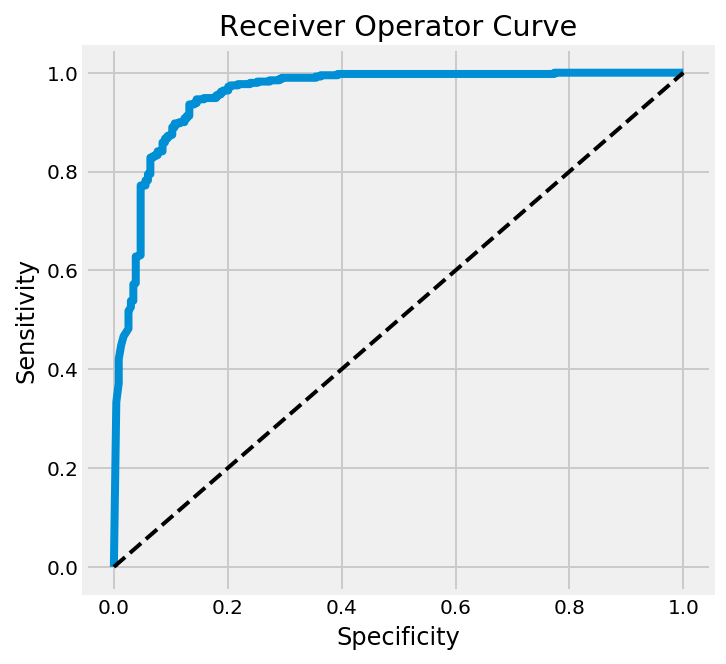

In [34]:
# Evaluate model
auc_roc(model_cnn)

In [15]:
# Function to calculate classification metrics and plot the confusion matrix 
def confusion_metrics(model):
    # Create a heatmap confusion matrix - get predictions 
    if type(model) == Sequential:
        pred = model.predict_classes(X_test)
    elif type(model) == Model:
        pred = model.predict(X_test)
        pred = np.argmax(pred,axis=1)
    
    # Create confusion matrix 
    classes = ["Normal", 'Pneumonia']
    cm  = metrics.confusion_matrix(test['label'], pred)
    cm_df = pd.DataFrame(cm, columns=classes)
    cm_df.index = classes

    # Plot matrix on heatmap 
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # Calculate classification metrics 
    tn, fp, fn, tp = cm.ravel()
    precision = tp /(tp + fp)
    sensitivity = tp /(tp + fn)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    specificity = tn / (tn + fp)

    print('Precision: ', precision)
    print('Sensitivity: ', sensitivity)
    print("Accuracy: ", accuracy)
    print('Specificity: ', specificity)

Precision:  0.8498896247240618
Sensitivity:  0.9871794871794872
Accuracy:  0.8830128205128205
Specificity:  0.7094017094017094


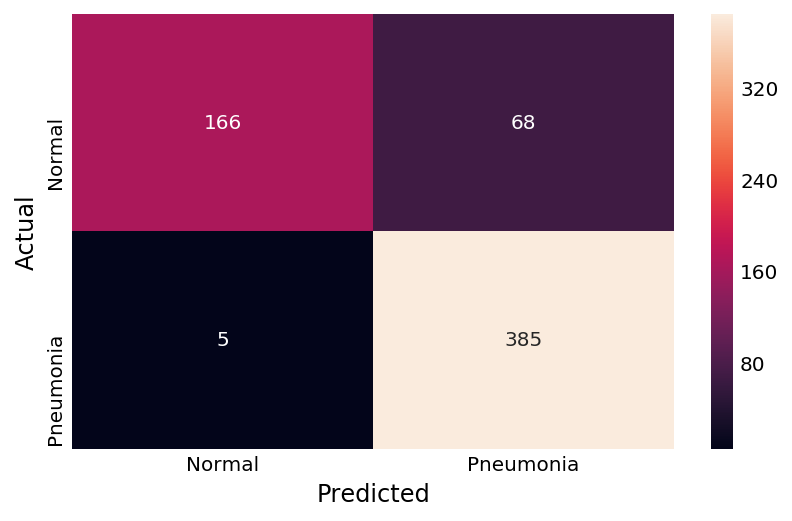

In [35]:
# Evaluate model
confusion_metrics(model_cnn)

In [16]:
# Function to plot the train and test performance in the model per epoch 
def train_test_eval(history, batch_size):
    # Loss vs val_loss plot
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    
    # Acc vs val_acc plot
    ax[1].plot(history.history['acc'])
    ax[1].plot(history.history['val_acc'])
    
    # Labels
    labels = ['Loss', 'Accuracy']
    for i in range(2):
        ax[i].set_title('Model ' + labels[i])
        ax[i].set_ylabel(labels[i])
        ax[i].set_xlabel('Epoch')
        ax[i].set_xticks(range(0,batch_size))
        ax[i].set_xticklabels(range(1,batch_size + 1))
        ax[i].legend(['Train', 'Test'], loc='best'); 

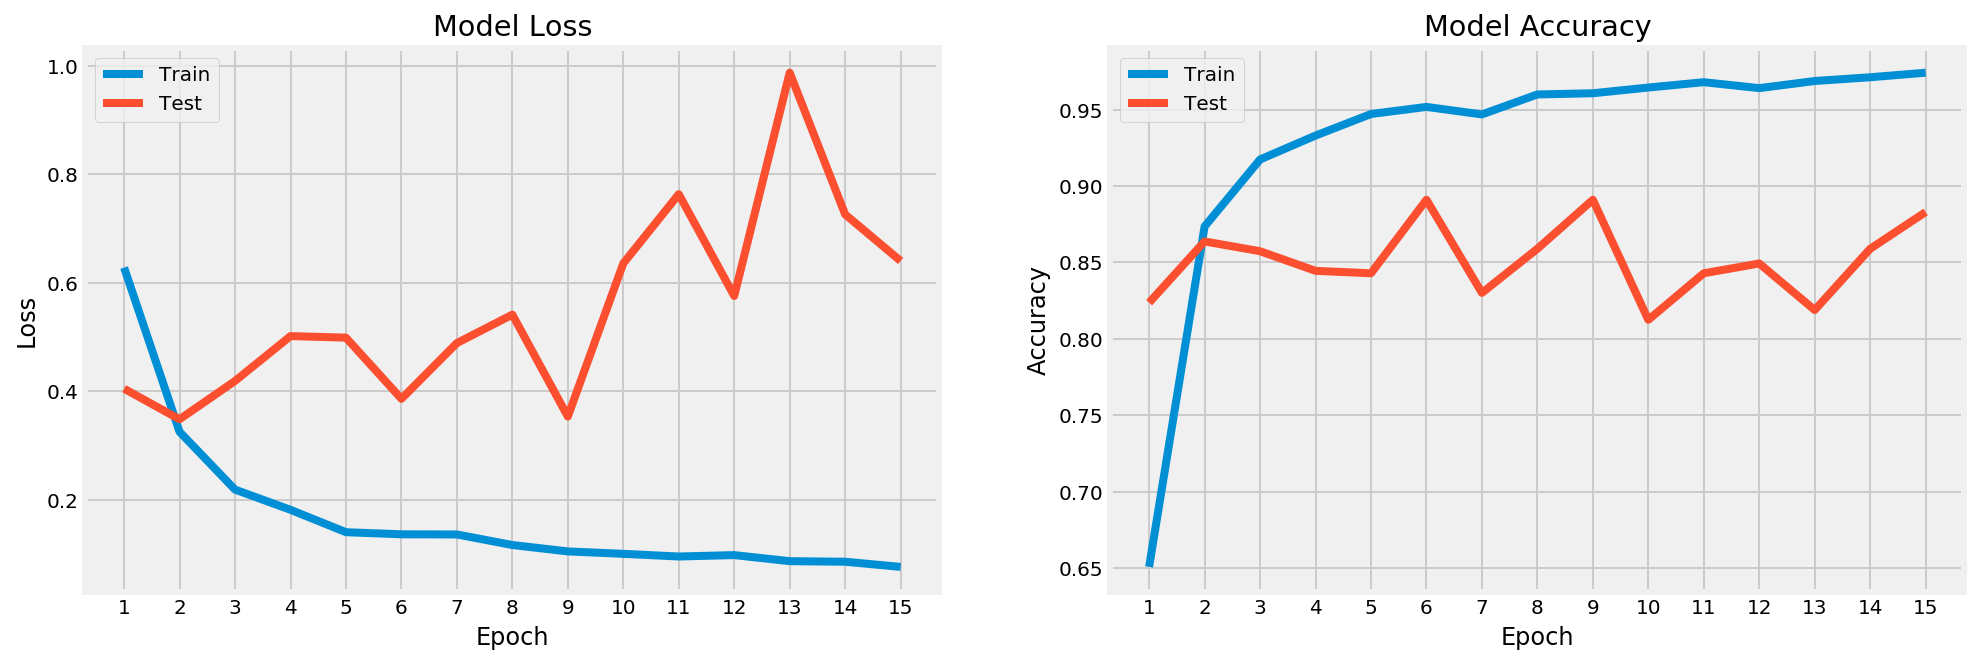

In [51]:
# Evaluate model
train_test_eval(history_cnn, 15)

<a id='transfer'></a>
#### Transfer Learning VGG16 Model & Evaluation

I selected the prebuilt Keras VGG16 deep learning model trained on the ImageNet dataset [3]. ImageNet is open source image dataset with tens of millions of images of various objects. Models trained on this dataset tend to generalize very well to many different types of images content. I chose the VGG16 model because compared to others available in Keras, VGG16 has competitive accuracy scores on the validation ImageNet set with the lowest depth. I suspect that using more layers might overfit my use case. I only used the bottom of the VGG16 model architecture with the associated pretrained weights and built a dense network on top to classify my dataset with the appropriate labels. This greatly limits the number of parameters that need to be trained since the basic structures of the images have already been identified by the out of the box pretrained weights.   

In [58]:
# Define VGG16 base model 
base = VGG16(weights = 'imagenet', include_top = False, input_shape = X_train.shape[1:])

# Use pretrained weights in base model
for layer in base.layers:
    layer.trainable = False

# Inspect VGG16 model architecture 
base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [59]:
# Define top output layer 
tf_model = Sequential()
tf_model.add(base)
tf_model.add(Flatten())
tf_model.add(Dense(2, activation='softmax'))

# Compile model
tf_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Model summary 
tf_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [60]:
# Fit model
history_tf = tf_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),epochs=10, 
                                  validation_data=(X_test, y_test), callbacks = [reduce_lr])

Epoch 1/10
243/243 [==============================] - 83s 341ms/step - loss: 0.1567 - acc: 0.9390 - val_loss: 0.3020 - val_acc: 0.9022
Epoch 2/10
243/243 [==============================] - 80s 330ms/step - loss: 0.0686 - acc: 0.9760 - val_loss: 0.5134 - val_acc: 0.8622
Epoch 3/10
243/243 [==============================] - 80s 331ms/step - loss: 0.0506 - acc: 0.9830 - val_loss: 0.4774 - val_acc: 0.8846
Epoch 4/10
243/243 [==============================] - 80s 331ms/step - loss: 0.0444 - acc: 0.9844 - val_loss: 0.8432 - val_acc: 0.8045
Epoch 5/10
243/243 [==============================] - 80s 329ms/step - loss: 0.0562 - acc: 0.9806 - val_loss: 1.4808 - val_acc: 0.7420
Epoch 6/10
243/243 [==============================] - 80s 329ms/step - loss: 0.0424 - acc: 0.9845 - val_loss: 0.9954 - val_acc: 0.8189
Epoch 7/10
243/243 [==============================] - 80s 330ms/step - loss: 0.0366 - acc: 0.9879 - val_loss: 0.7939 - val_acc: 0.8381
Epoch 8/10
243/243 [==============================] - 8

AUC-ROC:  0.9512628753013368


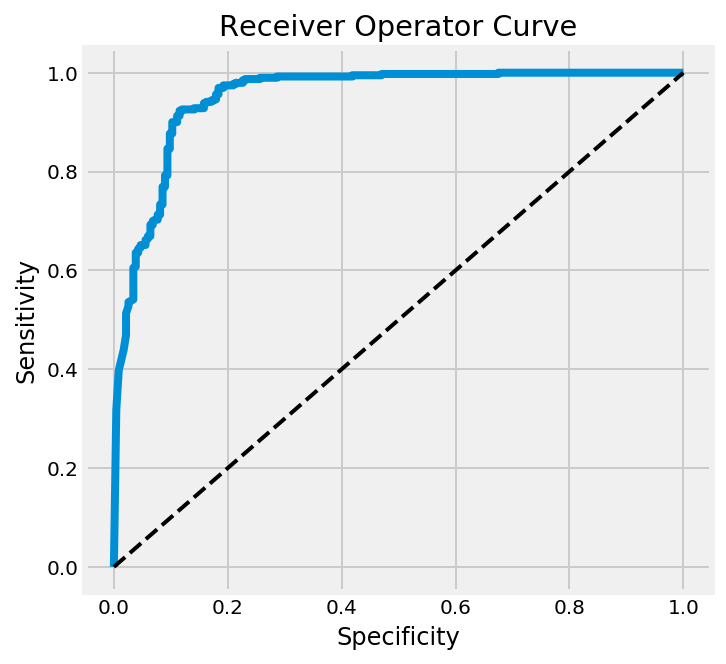

In [61]:
# Evaluate model
auc_roc(tf_model)

Precision:  0.779559118236473
Sensitivity:  0.9974358974358974
Accuracy:  0.8221153846153846
Specificity:  0.5299145299145299


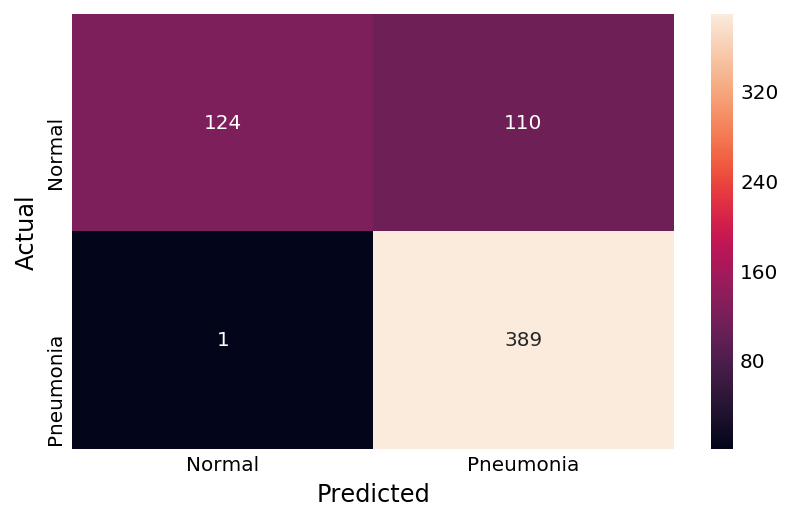

In [62]:
# Evaluate model
confusion_metrics(tf_model)

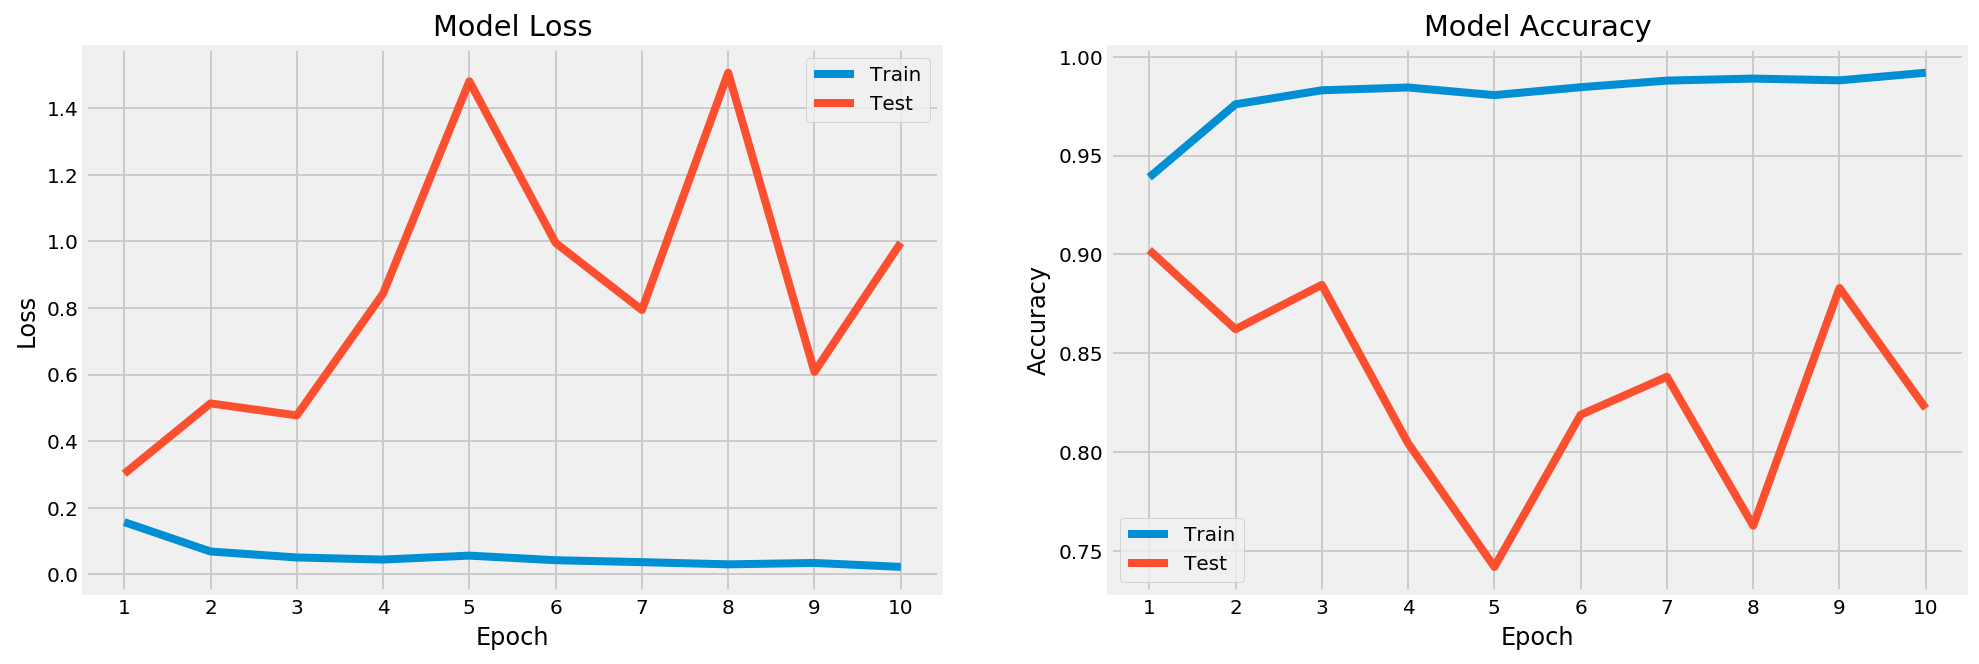

In [63]:
# Evaluate model
train_test_eval(history_tf, 10)

<a id='transfer_2'></a>
#### Transfer Learning InceptionV3 Model & Evaluation  
I also performed transfer learning with the Keras InceptionV3 model in order to try and replicate the results of the Kermany et al. study [2]. 

In [20]:
# Define InceptionV3 base model 
base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = X_train.shape[1:])

# Use pretrained weights in base model
for layer in base.layers:
    layer.trainable = False

# Inspect InceptionV3 model architecture 
base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_8 (

In [21]:
# Define top output layer 
inception_model = Sequential()
inception_model.add(base)
inception_model.add(Flatten())
inception_model.add(Dense(2, activation='softmax'))

# Compile model
inception_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Model summary
inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102402    
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
# Fit model
history_inception = inception_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),epochs=10, 
                                  validation_data=(X_test, y_test))

Epoch 1/10
243/243 [==============================] - 86s 355ms/step - loss: 0.7161 - acc: 0.8734 - val_loss: 2.7668 - val_acc: 0.6939
Epoch 2/10
243/243 [==============================] - 79s 325ms/step - loss: 0.5136 - acc: 0.9140 - val_loss: 4.9101 - val_acc: 0.5016
Epoch 3/10
243/243 [==============================] - 78s 322ms/step - loss: 0.5160 - acc: 0.9232 - val_loss: 2.2015 - val_acc: 0.7420
Epoch 4/10
243/243 [==============================] - 79s 325ms/step - loss: 0.5213 - acc: 0.9310 - val_loss: 3.0076 - val_acc: 0.7163
Epoch 5/10
243/243 [==============================] - 79s 326ms/step - loss: 0.5493 - acc: 0.9309 - val_loss: 2.5483 - val_acc: 0.7276
Epoch 6/10
243/243 [==============================] - 79s 325ms/step - loss: 0.5112 - acc: 0.9367 - val_loss: 4.1585 - val_acc: 0.6763
Epoch 7/10
243/243 [==============================] - 78s 322ms/step - loss: 0.6007 - acc: 0.9339 - val_loss: 3.6713 - val_acc: 0.6474
Epoch 8/10
243/243 [==============================] - 7

AUC-ROC:  0.7249260355029585


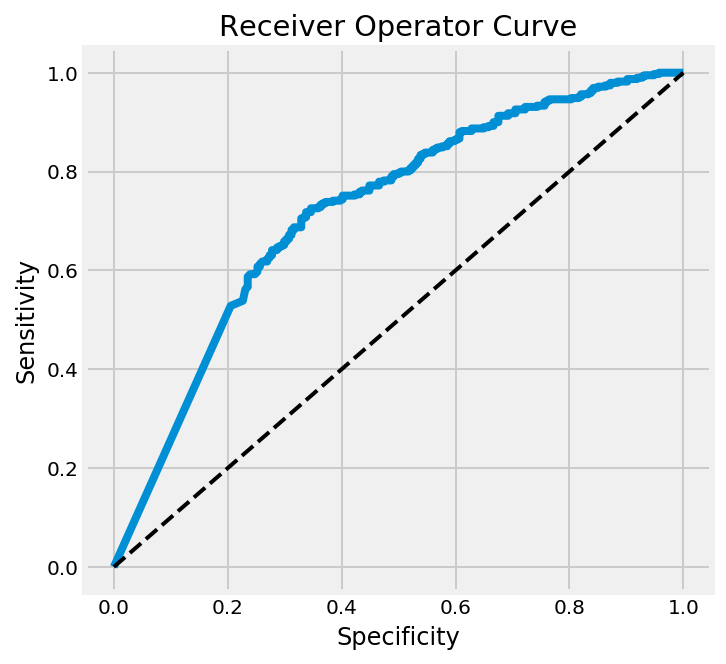

In [23]:
# Evaluate model
auc_roc(inception_model)

Precision:  0.7342995169082126
Sensitivity:  0.7794871794871795
Accuracy:  0.6858974358974359
Specificity:  0.5299145299145299


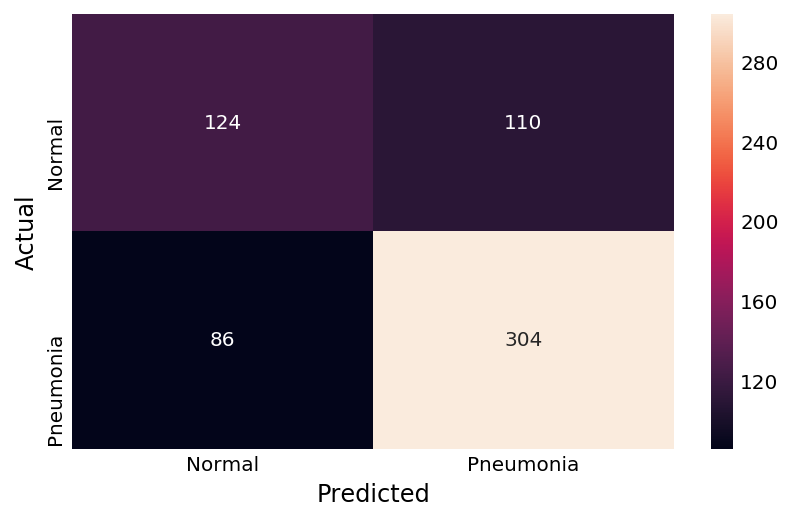

In [24]:
# Evaluate model
confusion_metrics(inception_model)

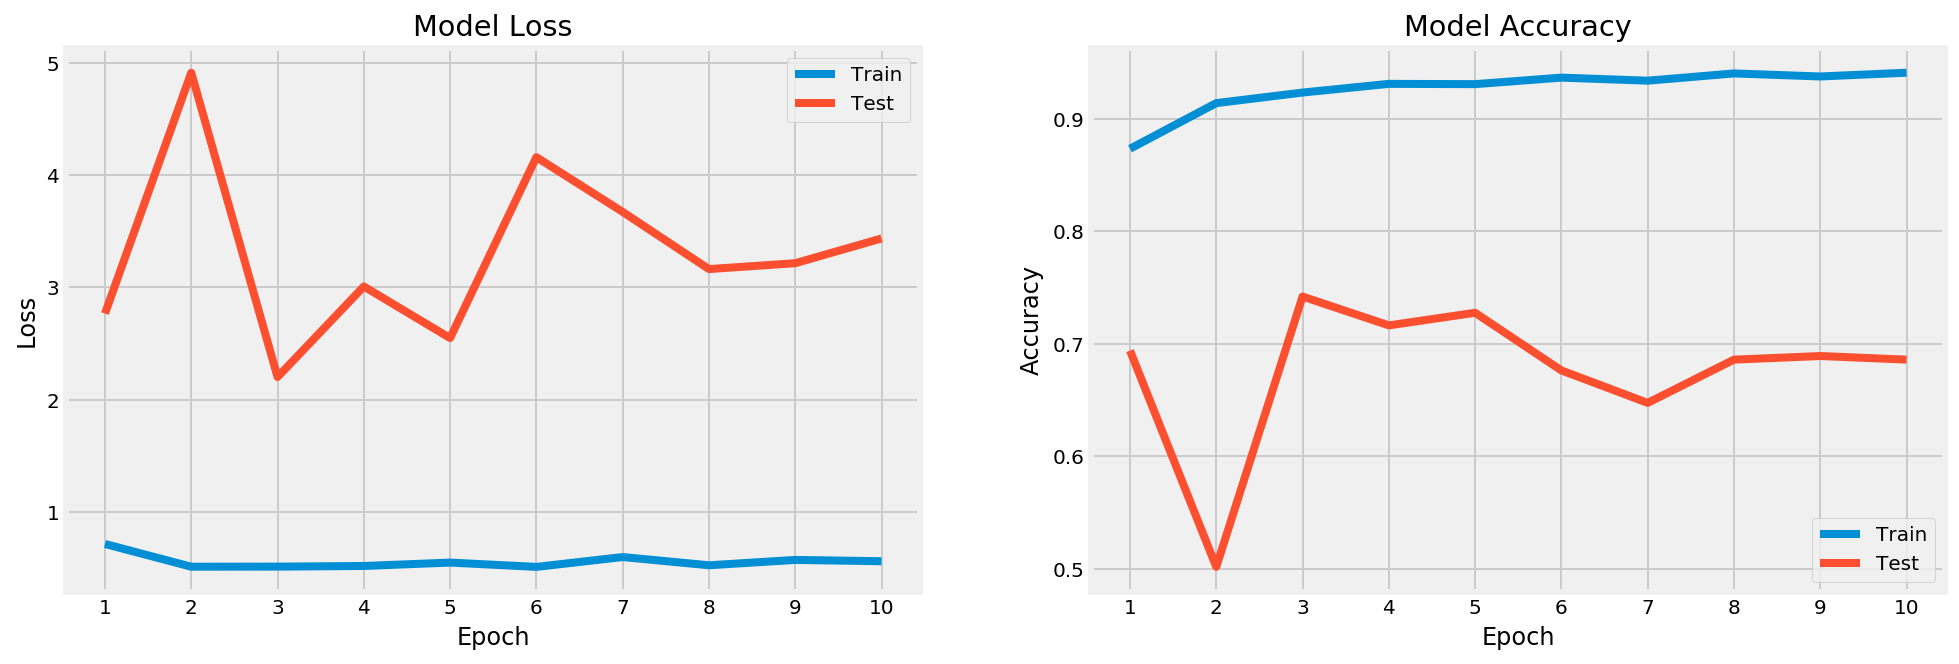

In [25]:
# Evaluate model 
train_test_eval(history_inception, 10)

<a id='conc'></a>
### Conclusions  

All 3 models suffered from overfitting in that the train and test loss and accuracy scores greatly differed and actually moved in opposite directions in subsequent epochs of training. In the CNN model I built, I incorporated dropout to reduce some overfitting and only used two dense layers to minimze the number of parameters to be trained considering the relatively small size of the dataset. I restricted one dense output layer for each transfer learning model for the same reason, to reduce the number of parameters to be trained. 

I evaluated my models on various metrics, such as AUC-ROC, accuracy, precision, sensitivity, and specificity, however, I paid particular attention to sensitivity. In the case of diagnosing pneumonia, we want to minimze predicting false negatives. Telling a patient they don't have pneumonia when they do can result in no treatment, which can be deadly. Alternatively, false positives, telling a patient they have pneumonia when they are healthy, isn't as damaging to the patient. In this case, a healthy patient would receive treatment, like antibiotics, that won't impact their health as negatively. In the worst possible case, antibiotics are known to decrease the diversity of bacteria in the gut, which can lead to stress, depression, and obesity [4]. It is important to note that there should be a balance between sensitivity and specificity in the case of pneumonia because the over prescription of antibiotics has led to the rise of antibiotic resistant bacteria. In fact, studies have found that upwards of 40% of antibiotics prescribed for acute respiratory tract infections, like pneumonia, are unnecessary [4]. Should this current trend of over prescription continue, it is possible that the bacteria that cause various infectious diseases will be resistant to antibiotics. With this in mind, I designed my CNN to minimize sensitivity to a certain extent, without letting specificity drop below 65%.       

Considering these metrics, my simple CNN performed the best with a AUC-ROC score of 0.96, 88% accuracy, 99% sensitivity, and 71% specificity. These results are close to that of human experts. I suspect that my model performed better than the transfer learning approaches due to its simplicity. Since neural networks inherintly overfit, a simpler model architecture will reduce overfitting. 

Interestingly enough, the InceptionV3 model performed the worst. Kermany et al. were able to achieve a 92% accuracy with this model, while I achieved 68% [2]. It is possible that they used different model hyperparameters, which were not available in their publication. In order to replicate their exact study, I would need more details. 

Nonetheless, I was able to demonstrate the feasability of using a CNN to diagnose pneumonia from chest X-rays with a respectable results. 

<a id='next'></a>
### Next Steps  

My immediate next steps are to apply this analysis to the 3 class problem of distinguishing normal chest X-rays from those with bacterial and viral pneumonia. You will find the full details of this work in the next notebook titled "2.Diagnosing_Pneumonia_3_Classes". I continue my discussion of overall next steps in this notebook.  


------------------------------------
<a id='ref'></a>
**References**

[1] World Health Organization,"Fact Sheet: Pneumonia", (2016), http://www.who.int/en/news-room/fact-sheets/detail/pneumonia 
  
[2] Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X- Ray Images for Classification”, Mendeley Data, v2, http://dx.doi.org/10.17632/rscbjbr9sj.2  

[3] Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. 

[4] Fiore, David C. et al. "Antibiotic overperscribing: still a major concern." Journal of Family Practice 66.12 (2017). https://www.mdedge.com/sites/default/files/Document/November-2017/JFP06612730.PDF 
